<a href="https://colab.research.google.com/github/shilpasy/Autoencoder-Bioinformatics-examples/blob/main/MultiModal_Omics_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook draws inspiration from the work of Nikolay Oskolkov in [DeepLearningDataIntegration](https://github.com/NikolayOskolkov/DeepLearningDataIntegration/). Here, my emphasis is on providing a comprehensive explanation of each step, accompanied by clear definitions of various terms, as a beginner-friendly content.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#!/usr/bin/python
# Nikolay Oskolkov, WABI Long-Term Support, nikolay.oskolkov@scilifelab.se

import os
import numpy as np
import pandas as pd
#from umap import UMAP
import matplotlib as mpl
from sklearn.manifold import TSNE
import keras
#from keras.utils import plot_model
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
scRNAseq = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DataIntegration-Omics/scRNAseq.txt', sep='\t')
scProteomics = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DataIntegration-Omics/scProteomics.txt', sep = '\t')

print(f"The dimensions of the scRNAseq data is {scRNAseq.shape} and dimensions of proteomics is {scProteomics.shape}. It is important to confirm that we are combining data with the same number of rows, that is cells here\n")

scRNAseq.head()

The dimensions of the scRNAseq data is (8617, 977) and dimensions of proteomics is (8617, 11). It is important to confirm that we are combining data with the same number of rows, that is cells here



,ABHD17A,ABHD5,ABI3,AC013264.2,AC017104.6,AC092580.4,AC093673.5,AC132872.2,ACRBP,ACSL1,...,MOUSE_Ppp1ca,MOUSE_Cald1,MOUSE_Rps26,MOUSE_Ctsl,MOUSE_Tnfrsf12a,MOUSE_Esd,MOUSE_Acta2,MOUSE_Arpc2,MOUSE_Calr,cluster
CTGTTTACACCGCTAG,0,0,0,0,0,0,0,0,0,0,...,38,161,22,133,57,58,5,66,21,4
CTCTACGGTGTGGCTC,0,0,0,0,0,0,0,0,0,0,...,67,85,60,77,55,70,69,52,33,4
AGCAGCCAGGCTCATT,0,0,0,0,0,0,0,0,1,0,...,69,87,60,112,74,37,27,68,76,4
GAATAAGAGATCCCAT,0,0,0,0,0,0,0,0,0,0,...,71,87,84,67,44,80,31,62,107,4
GTGCATAGTCATGCAT,0,0,0,0,0,0,0,0,0,0,...,88,128,58,23,29,13,547,93,31,4


In [4]:
scRNAseq.columns

Index(['ABHD17A', 'ABHD5', 'ABI3', 'AC013264.2', 'AC017104.6', 'AC092580.4',
       'AC093673.5', 'AC132872.2', 'ACRBP', 'ACSL1',
       ...
       'MOUSE_Ppp1ca', 'MOUSE_Cald1', 'MOUSE_Rps26', 'MOUSE_Ctsl',
       'MOUSE_Tnfrsf12a', 'MOUSE_Esd', 'MOUSE_Acta2', 'MOUSE_Arpc2',
       'MOUSE_Calr', 'cluster'],
      dtype='object', length=977)

In [5]:
columns_to_drop = scRNAseq.columns[scRNAseq.columns.str.contains('MOUSE_')]
scRNAseq = scRNAseq.drop(columns = columns_to_drop)

In [ ]:
scRNAseq.shape

(8617, 877)

In [6]:
scProteomics.head()

,CITE_CD3,CITE_CD4,CITE_CD8,CITE_CD45RA,CITE_CD56,CITE_CD16,CITE_CD11c,CITE_CD14,CITE_CD19,CITE_CD34,cluster
CTGTTTACACCGCTAG,60,72,76,575,64,161,77,206,70,179,4
CTCTACGGTGTGGCTC,52,49,59,3943,68,107,65,129,665,79,4
AGCAGCCAGGCTCATT,89,112,61,682,87,117,65,169,79,78,4
GAATAAGAGATCCCAT,55,66,56,378,58,82,44,136,49,83,4
GTGCATAGTCATGCAT,63,80,94,644,104,168,92,164,81,152,4


Notice that we have scRNAseq and proteomics data from the same cell barcodes. As usual, rows are cells, columns are mRNA or protein features. Last column corresponds to cluster assignments.

**Preprocessing the data to get input features (X) and target labels (Y) for both datasets**

In [7]:
X_scRNAseq = scRNAseq.values[:,0:(scRNAseq.shape[1]-1)]
Y_scRNAseq = scRNAseq.values[:,scRNAseq.shape[1]-1]
X_scProteomics = scProteomics.values[:,0:(scProteomics.shape[1]-1)]
Y_scProteomics = scProteomics.values[:,scProteomics.shape[1]-1]
# The X data is extracted using array slicing to remove the last column, while the Y data is obtained by selecting only the last column of the data.
print("\n")
print(" scRNAseq features: \n ", X_scRNAseq[0:5,0:5])
print(" RNAseq target labels: \n", Y_scRNAseq[0:5])

# LOG-TRANSFORM DATA
# Natural logarithm transformation is applied to X data so that extreme value do not impact much and +1 is added to avoid taking log(0)
X_scRNAseq = np.log(X_scRNAseq + 1)
X_scProteomics = np.log(X_scProteomics + 1)



 scRNAseq features: 
  [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
 RNAseq target labels: 
 [4 4 4 4 4]


# AutoEncoder

Why autoencoders are used here?

It is a neural network trained to learn how to produce its input data. It does this in two steps, encodes input into a lower-dimensional representation and then decodes it back to the original format. During this process, here, it learns a joint representation of the input data, capturing essential features from both scRNAseq and scProteomics.

In [8]:
# Input Layer
# The Input function defines placeholders for the input data.
ncol_scRNAseq = X_scRNAseq.shape[1]
input_dim_scRNAseq = keras.layers.Input(shape = (ncol_scRNAseq, ), name = "scRNAseq")
ncol_scProteomics = X_scProteomics.shape[1]
input_dim_scProteomics = keras.layers.Input(shape = (ncol_scProteomics, ), name = "scProteomics")

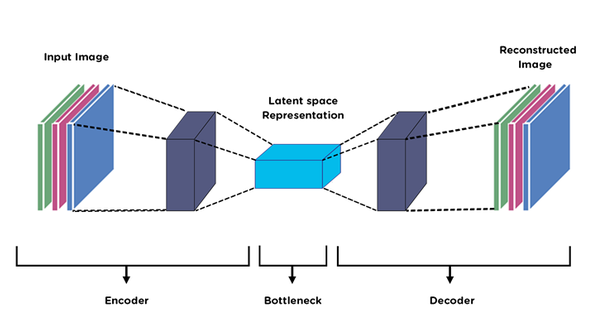

**Encoder**

In [9]:
# Dimensions of Encoder for each OMIC
# Encoder Dimensions specifies the dimensions of the encoder layers for each omics dataset.
encoding_dim_scRNAseq = 50 # The first hidden layer imposes severe dimensionality reduction on the scRNAseq from 977 to 50 genes ...
encoding_dim_scProteomics = 10 # while it leaves the scProteomics almost untouched, i.e. reduces dimensions from 11 to 10, because we have very few datapoints from scProteomics data.

### Regularization  ### This is optional set of parameters to explore when you are not satisfied with the results
#dropout_rate = 0.3
#regularization_strength = 0.005

### Encoder layer for each OMIC
# These layers are responsible for reducing the dimensionality of the input data

"""
encoded_scRNAseq = keras.layers.Dense(encoding_dim_scRNAseq, activation = 'linear', kernel_regularizer= keras.regularizers.l2(regularization_strength), name = "Encoder_scRNAseq")(input_dim_scRNAseq)
encoded_scRNAseq = keras.layers.Dropout(dropout_rate)(encoded_scRNAseq)
encoded_scProteomics = keras.layers.Dense(encoding_dim_scProteomics, activation = 'linear',  kernel_regularizer= keras.regularizers.l2(regularization_strength), name = "Encoder_scProteomics")(input_dim_scProteomics)
encoded_scProteomics = keras.layers.Dropout(dropout_rate)(encoded_scProteomics)
"""

encoded_scRNAseq = keras.layers.Dense(encoding_dim_scRNAseq, activation = 'linear', name = "Encoder_scRNAseq")(input_dim_scRNAseq)
encoded_scProteomics = keras.layers.Dense(encoding_dim_scProteomics, activation = 'linear', name = "Encoder_scProteomics")(input_dim_scProteomics)

**Bottleneck**

First we need to merge encoder layers from scRNAseq and Proteomics and then apply compression

The concatenate function is a powerful tool for merging or concatenating data in neural network architectures, especially when you're dealing with multi-modal or multi-source data integration tasks, as seen here.

In [10]:
merge = keras.layers.concatenate([encoded_scRNAseq, encoded_scProteomics])
#The shape of this merged representation will be (batch_size, encoding_dim_scRNAseq + encoding_dim_scProteomics), as the concatenation is performed along the last axis (features).

### Bottleneck compression
# This is the most important step where data is compressed in an efficient manner
""" bottleneck = keras.layers.Dense(50, kernel_initializer = 'uniform', kernel_regularizer= keras.regularizers.l2(regularization_strength), activation = 'linear', name = "Bottleneck")(merge) """
bottleneck = keras.layers.Dense(50, kernel_initializer = 'uniform', activation = 'linear', name = "Bottleneck")(merge)
# a dense (fully connected) layer with 50 neurons, weights from randomly sampled from a uniform distribution, 'linear' activation function


**Inverse merging**

This layer attempts to reconstruct the concatenated representation from the compressed bottleneck representation.

In [12]:
# The idea is that the model learns a useful representation in the bottleneck layer that captures the essential features of the input data.
merge_inverse = keras.layers.Dense(encoding_dim_scRNAseq + encoding_dim_scProteomics, activation = 'elu', name = "Concatenate_Inverse")(bottleneck)
# another dense (fully connected) layer, num neurons = sum of the dimensions of the encoded representations, 'elu' activation function is Exponential Linear Unit

ELU is known for handling the vanishing gradient problem better than some other activation functions, and it allows the model to learn non-linear relationships in the data during the decoding process.


*what is the difference between Inverse merging and decoding* ?

"Inverse merging" brings the data back from the bottleneck to a higher-dimensional space. Decoding further refines this representation to match the original input.

The activation function for Inverse merging here is '**elu**'which introduce non-linearities to the model and allows it to capture complex relationships in the data.

The activation function used for decoding here is **sigmoid** to normalize the data at autoencoder's ouput layer between 0 and 1.

**Decoder**


In [13]:
# This decoder layer attempts to reconstruct the original input from the compressed
"""
decoded_scRNAseq = keras.layers.Dense(ncol_scRNAseq, activation = 'sigmoid', kernel_regularizer= keras.regularizers.l2(regularization_strength), name = "Decoder_scRNAseq")(merge_inverse)
decoded_scRNAseq = keras.layers.Dropout(dropout_rate)(decoded_scRNAseq)

decoded_scProteomics = keras.layers.Dense(ncol_scProteomics, activation = 'sigmoid', kernel_regularizer= keras.regularizers.l2(regularization_strength), name = "Decoder_scProteomics")(merge_inverse)
decoded_scProteomics = keras.layers.Dropout(dropout_rate)(decoded_scProteomics)
"""
decoded_scRNAseq = keras.layers.Dense(ncol_scRNAseq, activation = 'sigmoid', name = "Decoder_scRNAseq")(merge_inverse)
decoded_scProteomics = keras.layers.Dense(ncol_scProteomics, activation = 'sigmoid', name = "Decoder_scProteomics")(merge_inverse)

Even though we decode scRNAseq and scProteomics separately, the details stored in the bottleneck layer are used to rebuild each kind of data on its own. This way, the shared information in the bottleneck helps in putting together both types of data again, letting the model grasp connections that are common to both.

**Combining Encoder and Decoder into an Autoencoder model**

The autoencoder is designed to take both scRNAseq and scProteomics data as input and output reconstructed versions of each.

The architecture of this autoencoder allows it to simultaneously learn representations of both scRNAseq and scProteomics data, and capturing joint information and relationships between the two types of omics data.

After training, the encoder can be used to obtain the learned representations for downstream tasks, and the decoder can be used to generate reconstructed data.

In [14]:
autoencoder = keras.models.Model(inputs = [input_dim_scRNAseq, input_dim_scProteomics], outputs = [decoded_scRNAseq, decoded_scProteomics])
# The autoencoder is trained to learn a compressed, joint representation of the input data in the bottleneck layer. This representation is then used for decoding each omics data type separately.

# Compile Autoencoder
autoencoder.compile(optimizer = 'adam', loss={'Decoder_scRNAseq': 'mean_squared_error', 'Decoder_scProteomics': 'mean_squared_error'})
"""autoencoder.compile(optimizer='adam', loss=['mean_squared_error', 'mean_squared_error'])  # Update the loss here"""
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 scRNAseq (InputLayer)       [(None, 876)]                0         []                            
                                                                                                  
 scProteomics (InputLayer)   [(None, 10)]                 0         []                            
                                                                                                  
 Encoder_scRNAseq (Dense)    (None, 50)                   43850     ['scRNAseq[0][0]']            
                                                                                                  
 Encoder_scProteomics (Dens  (None, 10)                   110       ['scProteomics[0][0]']        
 e)                                                                                           

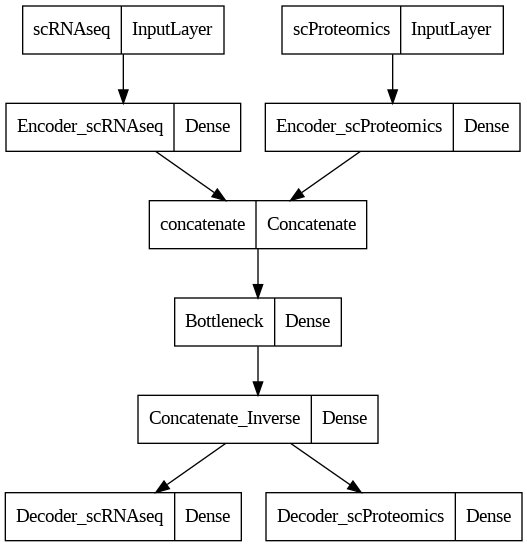

In [15]:
# Autoencoder graph
#keras.utils.plot_model(autoencoder, to_file='autoencoder_graph.png')
keras.utils.plot_model(autoencoder)

**Autoencoder training**

In [16]:
#early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
estimator = autoencoder.fit(
    [X_scRNAseq, X_scProteomics],
    [X_scRNAseq, X_scProteomics],
    epochs=100,
    batch_size=128,
    validation_split=0.2,
    shuffle=True,
    verbose=1
    )
    #callbacks=[early_stopping]
    #)

print("Training Loss: ",estimator.history['loss'][-1])
print("Validation Loss: ",estimator.history['val_loss'][-1])

Epoch 1/100
54/54 [==============================] - 9s 14ms/step - loss: 17.6393 - Decoder_scRNAseq_loss: 0.1710 - Decoder_scProteomics_loss: 17.4683 - val_loss: 15.3907 - val_Decoder_scRNAseq_loss: 0.0801 - val_Decoder_scProteomics_loss: 15.3106
Epoch 2/100
54/54 [==============================] - 0s 8ms/step - loss: 16.9703 - Decoder_scRNAseq_loss: 0.1113 - Decoder_scProteomics_loss: 16.8590 - val_loss: 15.3887 - val_Decoder_scRNAseq_loss: 0.0788 - val_Decoder_scProteomics_loss: 15.3099
Epoch 3/100
54/54 [==============================] - 0s 8ms/step - loss: 16.9679 - Decoder_scRNAseq_loss: 0.1091 - Decoder_scProteomics_loss: 16.8588 - val_loss: 15.3880 - val_Decoder_scRNAseq_loss: 0.0784 - val_Decoder_scProteomics_loss: 15.3096
Epoch 4/100
54/54 [==============================] - 1s 14ms/step - loss: 16.9658 - Decoder_scRNAseq_loss: 0.1071 - Decoder_scProteomics_loss: 16.8586 - val_loss: 15.3872 - val_Decoder_scRNAseq_loss: 0.0778 - val_Decoder_scProteomics_loss: 15.3094
Epoch 5/10

Note that the inputs and the target outputs are same for training. The model aims to minimize the difference between the input and reconstructed output.

During the training phase, the autoencoder is optimized to minimize the reconstruction error. The model learns to encode the input data into the bottleneck layer in a way that facilitates accurate reconstruction during the decoding phase.

*What exactly happens during the autoencoder training process?*

--> The weights and biases of the encoder layers (encoded_scRNAseq and encoded_scProteomics) are adjusted to transform the input data into a lower-dimensional representation in the bottleneck layer.

--> Merging Encoder Layers

--> The weights and biases of 'bottleneck' layer are adjusted during training.

--> Inverse Merging

--> Decoder Layers

The layers are created and executed within the training loop, contributing to the learning of a joint representation in the bottleneck layer and the reconstruction of the input data.


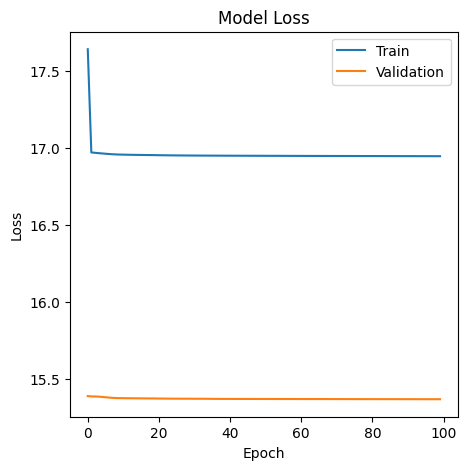

In [17]:
plt.figure(figsize=(5, 5))
plt.plot(estimator.history['loss'])
plt.plot(estimator.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc = 'upper right')
plt.show()

#Encoder model for downstream processing

Note that it takes the same inputs as the original autoencoder but outputs only the bottleneck layer


270/270 [==============================] - 1s 2ms/step
size of bottleneck layer (8617, 50)
a glimpse at bottleneck layer           0         1         2         3         4
0 -2.185803 -4.537687  5.257144 -5.212400 -5.454216
1 -1.059075 -5.322236  5.644834 -5.537693 -5.404229
2  0.100970 -4.124626  5.164523 -4.879714 -4.945472
3  0.731811 -3.697133  4.573356 -4.600678 -5.003578
4 -1.585749 -3.989393  5.481601 -5.130054 -5.282643


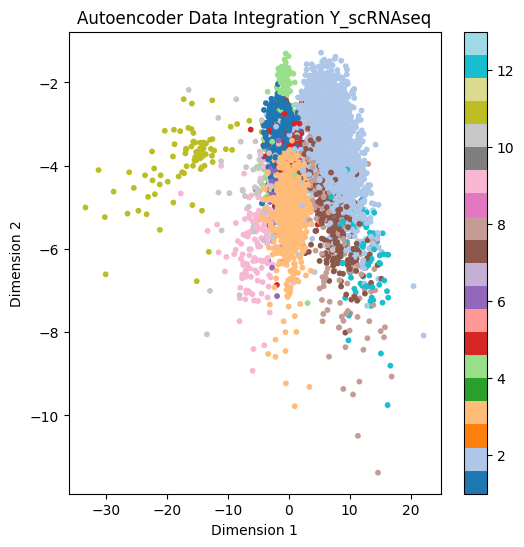

In [18]:
# Why we need new encoder model here: For analysis like dimensionality reduction, feature extraction ...

"""bottleneck = keras.layers.Dense(20, kernel_initializer = 'uniform', kernel_regularizer= keras.regularizers.l2(regularization_strength), activation = 'linear', name = "Bottleneck")(merge)"""

encoder = keras.models.Model(inputs = [input_dim_scRNAseq, input_dim_scProteomics], outputs = bottleneck)
bottleneck_representation = encoder.predict([X_scRNAseq, X_scProteomics])

print("size of bottleneck layer", pd.DataFrame(bottleneck_representation).shape)
print( "a glimpse at bottleneck layer", pd.DataFrame(bottleneck_representation).iloc[0:5,0:5])

# Dimensionality reduction plot
plt.figure(figsize=(6, 6))
plt.scatter(bottleneck_representation[:, 0], bottleneck_representation[:, 1], c = Y_scRNAseq, cmap = 'tab20', s = 10)
plt.title('Autoencoder Data Integration Y_scRNAseq')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.colorbar()
plt.show()

# tSNE on Autoencoder bottleneck representation

We want to visualize the high-dimensional, compressed information learned by the autoencoder in a lower-dimensional space.
It should also tell us how well the autoencoder has captured joint information from both types of omics data in the bottleneck layer.


[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 8617 samples in 0.001s...
[t-SNE] Computed neighbors for 8617 samples in 1.402s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8617
[t-SNE] Computed conditional probabilities for sample 2000 / 8617
[t-SNE] Computed conditional probabilities for sample 3000 / 8617
[t-SNE] Computed conditional probabilities for sample 4000 / 8617
[t-SNE] Computed conditional probabilities for sample 5000 / 8617
[t-SNE] Computed conditional probabilities for sample 6000 / 8617
[t-SNE] Computed conditional probabilities for sample 7000 / 8617
[t-SNE] Computed conditional probabilities for sample 8000 / 8617
[t-SNE] Computed conditional probabilities for sample 8617 / 8617
[t-SNE] Mean sigma: 1.636892
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.200302
[t-SNE] KL divergence after 1000 iterations: 1.510999


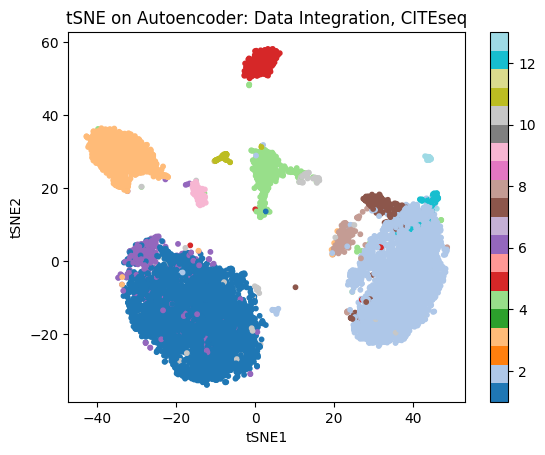

In [19]:
model_tsne_auto = TSNE(learning_rate = 200, n_components = 2, random_state = 123, perplexity = 90, n_iter = 1000, verbose = 1)

tsne_auto = model_tsne_auto.fit_transform(bottleneck_representation)

plt.scatter(tsne_auto[:, 0], tsne_auto[:, 1], c = Y_scRNAseq, cmap = 'tab20', s = 10)
plt.title('tSNE on Autoencoder: Data Integration, CITEseq')
plt.xlabel("tSNE1")
plt.ylabel("tSNE2")
plt.colorbar()
plt.show()

# UNIFORM MANIFOLD APPROXIMATION AND PROJECTION (UMAP)
#model_umap = UMAP(n_neighbors = 20, min_dist = 0.3, n_components = 2)
#umap = model_umap.fit_transform(bottleneck_representation)
#plt.scatter(umap[:, 0], umap[:, 1], c = Y_scRNAseq, cmap = 'tab20', s = 10)
#plt.title('UMAP on Autoencoder')
#plt.xlabel("UMAP1")
#plt.ylabel("UMAP2")
#plt.show()

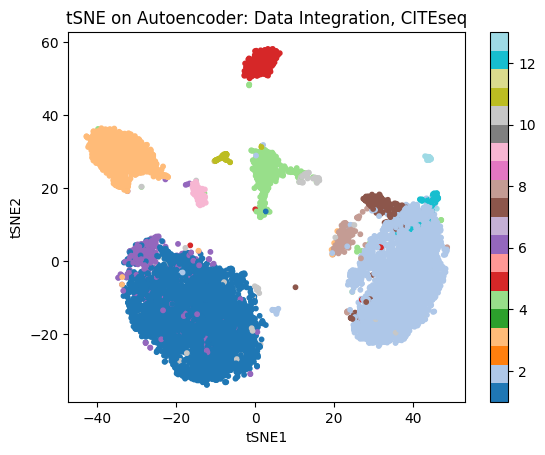

In [22]:
model_tsne_auto = TSNE(learning_rate=500, n_components=2, random_state = 13, perplexity = 30, n_iter = 1000, verbose = 1)
plt.scatter(tsne_auto[:, 0], tsne_auto[:, 1], c = Y_scRNAseq, cmap = 'tab20', s = 10)
plt.title('tSNE on Autoencoder: Data Integration, CITEseq')
plt.xlabel("tSNE1")
plt.ylabel("tSNE2")
plt.colorbar()
plt.show()

In [ ]:
# VISUALIZE AUTOENCODER
#from ann_visualizer.visualize import ann_viz
#ann_viz(model, title = "Autoencoder", view = True)

In [ ]:
#pip install ann_visualizer
#!pip install scvi-tools
#!pip install scanpy